In [1]:
import os
import pandas as pd
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from bayes_ts_funcs import generate_gam_ar1likelihood, gam_input
tfd = tfp.distributions


Bad key keymap.all_axes in file /Users/jhaberstroh/.matplotlib/matplotlibrc, line 15 ('keymap.all_axes : a # enable all axes')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


[0.07692308 0.15384616 0.23076923 0.30769232 0.3846154  0.46153846
 0.53846157 0.61538464 0.6923077  0.7692308  0.84615386 0.9230769 ]


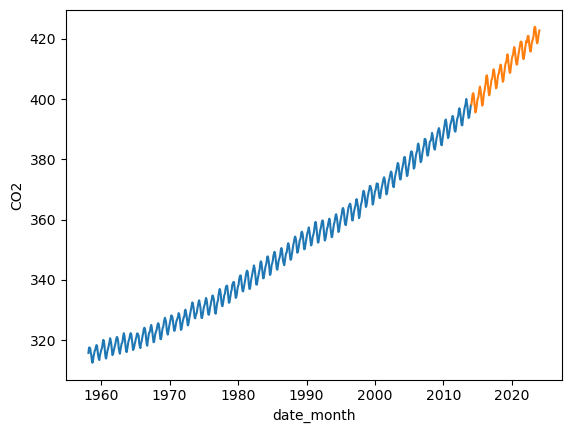

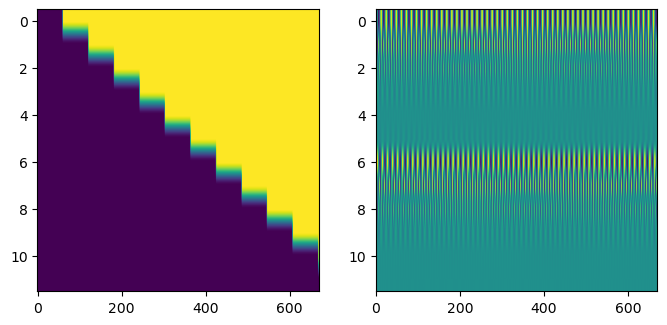

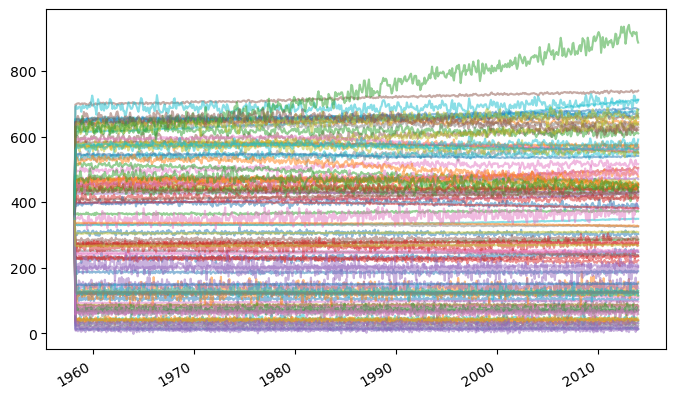

In [2]:
co2_by_month = pd.read_csv("co2_mm_mlo.csv",comment='#')
co2_by_month["date_month"] = pd.to_datetime(
    co2_by_month["year"].astype("str")
    .str.cat(['-']*co2_by_month.shape[0])
    .str.cat(co2_by_month["month"].astype("str"))
)
co2_by_month["CO2"] = co2_by_month["average"].astype(np.float32)
co2_by_month.set_index("date_month", drop=True, inplace=True)

num_forecast_steps = 12 * 10  # Forecast the final ten years, given previous data
num_steps_all = co2_by_month.shape[0]
num_steps = num_steps_all - num_forecast_steps
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]
sns.lineplot(co2_by_month_training_data, x="date_month", y="CO2")
sns.lineplot(co2_by_month_testing_data, x="date_month", y="CO2")


# Get and display inputs
(X_cp_all, X_season_all, s), (X_cp, X_season, _) = gam_input(num_steps_all, num_forecast_steps)
fig,ax=plt.subplots(1,2, figsize=(8, 5))
ax[0].imshow(X_cp.T, aspect = X_cp.shape[0] / X_cp.shape[1])
ax[1].imshow(X_season.T, aspect = X_season.shape[0] / X_season.shape[1])
print(s)


# Get model and generate baselines
gam = generate_gam_ar1likelihood(
    X_cp_all,
    X_season_all,
    s,
    num_steps_all,
    num_forecast_steps,
    co2_by_month_training_data["CO2"].mean()
)
prior_samples = gam.sample(100)  
prior_predictive_timeseries = prior_samples.y_obs
t = co2_by_month.index[:-num_forecast_steps]
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t,tf.transpose(prior_samples.y_obs), alpha=.5)
fig.autofmt_xdate()

In [3]:
seed = 24
os.environ['TF_DETERMINISTIC_OPS'] = 'true'
os.environ['PYTHONHASHSEED'] = f'{seed}'
np.random.seed(seed)
tf.random.set_seed(seed)

run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False,
    jit_compile=True,
)
mcmc_samples, sampler_stats = run_mcmc(
    1000,
    gam.experimental_pin(y_obs=co2_by_month_training_data["CO2"].values.T), 
    n_chains=4,
    num_adaptation_steps=1000,
    # Prepend batch index with [None]
)
regression_idata = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expects.
        k:np.swapaxes(v.numpy(), 1, 0)
        for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    }
)
regression_idata

2024-02-13 21:55:21.116178: I external/local_xla/xla/service/service.cc:168] XLA service 0x2de6955c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-13 21:55:21.116196: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-02-13 21:55:21.425284: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-13 21:55:21.582563: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2024-02-13 21:55:21.741696: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1707890133.689831       1 device_compiler.h:186] Compiled 

Inference data with groups:
	> posterior
	> sample_stats

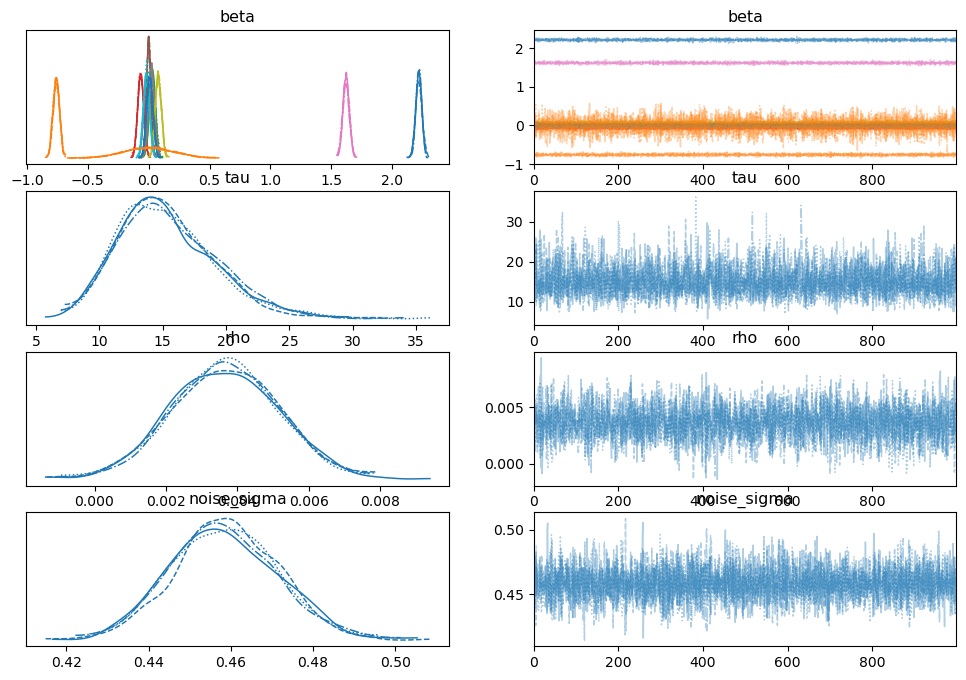

In [4]:
axes = az.plot_trace(
    regression_idata,
    var_names=['beta', 'tau', 'rho', 'noise_sigma'],
    compact=True
)

/var/folders/mh/2xmd8gxn1g94m_ptkk4trpl40000gp/T/ipykernel_20527/940516324.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


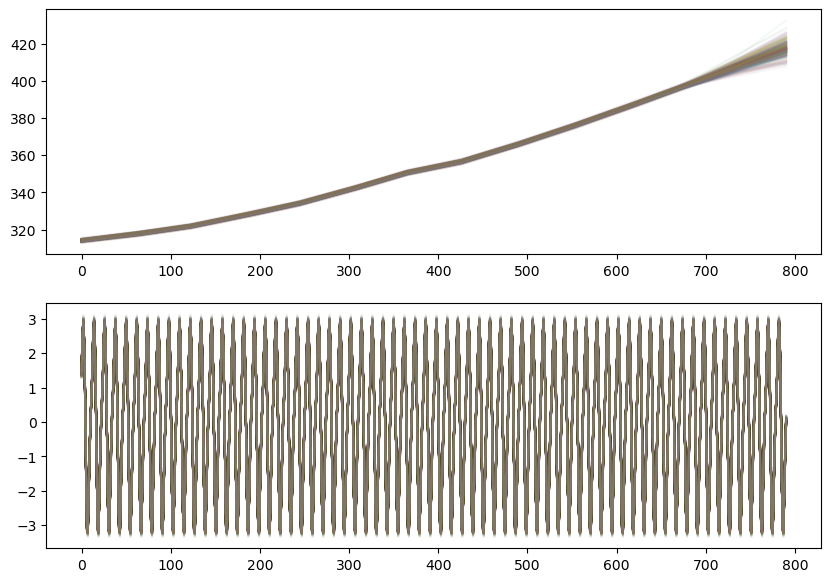

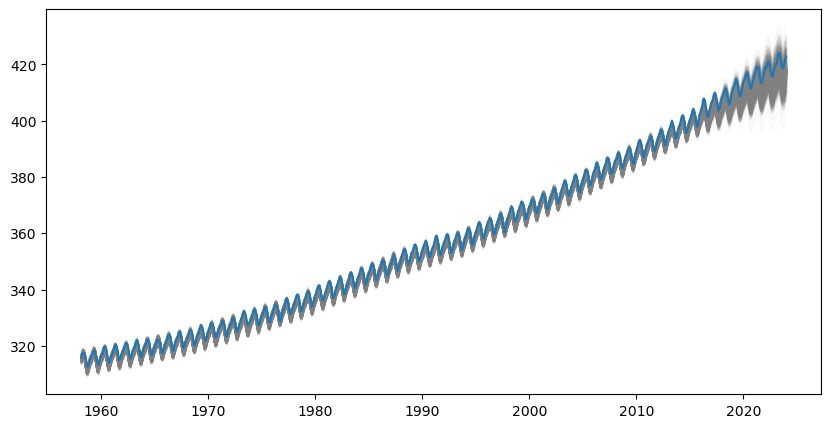

In [6]:
n_chain = regression_idata.posterior.dims["chain"]

k, m, tau, delta = mcmc_samples[1:5]

grow_rate = k[..., None] + tf.einsum('ij,...j->...i', X_cp_all, delta)
y_offset = m[..., None] + tf.einsum("ij,...j->...i", X_cp_all, -s * delta)

t = tf.cast(tf.linspace(0, 1, num_steps_all), np.float32)
y_trend = grow_rate * t + y_offset
y_season = tf.einsum('ij,...j->...i', X_season_all, mcmc_samples[0])

fig,ax = plt.subplots(2,1, figsize=(10, 7))
for i in range(regression_idata.posterior.dims["chain"]):
    ax[0].plot(y_trend[-100:,i,:].numpy().T, alpha=.05)
    ax[1].plot(y_season[-100:,i,:].numpy().T, alpha=.05)

posterior_predictive_dist = tfd.Normal(y_trend+y_season, mcmc_samples.noise_sigma[..., None])
post_y_sample = tf.transpose(posterior_predictive_dist.sample())
post_y_sample.shape

fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(co2_by_month.index, post_y_sample[:,2,:], color='grey', alpha=.05)
ax.plot(co2_by_month.index, co2_by_month["CO2"].values)
fig.show()

In [7]:
import os
import pandas as pd
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from bayes_ts_funcs import generate_gam_ar1, gam_input
tfd = tfp.distributions

[0.07692308 0.15384616 0.23076923 0.30769232 0.3846154  0.46153846
 0.53846157 0.61538464 0.6923077  0.7692308  0.84615386 0.9230769 ]


ValueError: x and y can be no greater than 2D, but have shapes (671,) and (671, 100, 100)

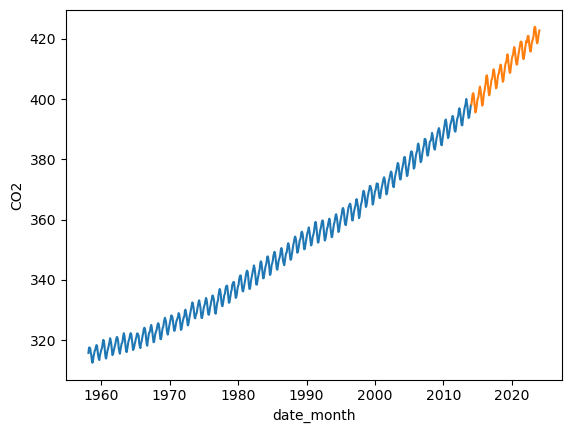

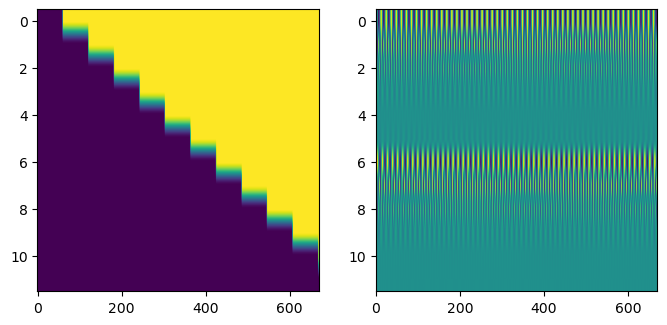

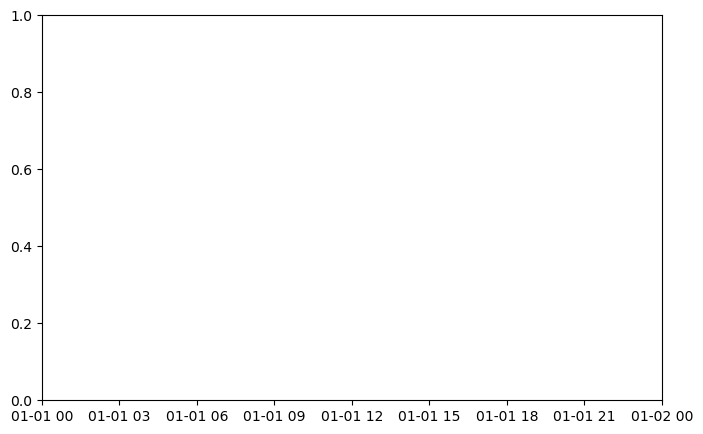

In [8]:
co2_by_month = pd.read_csv("co2_mm_mlo.csv",comment='#')
co2_by_month["date_month"] = pd.to_datetime(
    co2_by_month["year"].astype("str")
    .str.cat(['-']*co2_by_month.shape[0])
    .str.cat(co2_by_month["month"].astype("str"))
)
co2_by_month["CO2"] = co2_by_month["average"].astype(np.float32)
co2_by_month.set_index("date_month", drop=True, inplace=True)

num_forecast_steps = 12 * 10  # Forecast the final ten years, given previous data
num_steps_all = co2_by_month.shape[0]
num_steps = num_steps_all - num_forecast_steps
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]
sns.lineplot(co2_by_month_training_data, x="date_month", y="CO2")
sns.lineplot(co2_by_month_testing_data, x="date_month", y="CO2")


# Get and display inputs
(X_cp_all, X_season_all, s), (X_cp, X_season, _) = gam_input(num_steps_all, num_forecast_steps)
fig,ax=plt.subplots(1,2, figsize=(8, 5))
ax[0].imshow(X_cp.T, aspect = X_cp.shape[0] / X_cp.shape[1])
ax[1].imshow(X_season.T, aspect = X_season.shape[0] / X_season.shape[1])
print(s)


# Get model and generate baselines
gam = generate_gam_ar1(
    X_cp_all,
    X_season_all,
    s,
    num_steps_all,
    num_forecast_steps,
    co2_by_month_training_data["CO2"].mean()
)
prior_samples = gam.sample(100)  
prior_predictive_timeseries = prior_samples.y_obs
t = co2_by_month.index[:-num_forecast_steps]
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t,tf.transpose(prior_samples.y_obs), alpha=.5)
fig.autofmt_xdate()

2024-02-13 21:58:29.876736: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator chain_of_default_joint_bijector_of_restructure/ldj_reduction_ndims/assert_equal_1/Assert/Assert
2024-02-13 21:58:29.885625: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator chain_of_default_joint_bijector_of_restructure_of_jointmap_of_reshape_and_reshape_1_and_reshape_2_and_reshape_3_and_reshape_4_and_reshape_5_and_reshape_6_and_reshape_7_and_reshape_8/ldj_reduction_ndims_9/assert_equal_1/Assert/Assert
2024-02-13 21:58:35.425739: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
2024-02-13 21:58:35.426324: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator StatefulPartitionedCall/chain_of_default_joint_bijector_of_restructure_of_jointmap_of_reshape_and_reshape_1_and_reshape_2_and_reshape_3_and_reshape_4_and_reshape_5_and_reshape_6_and_resh

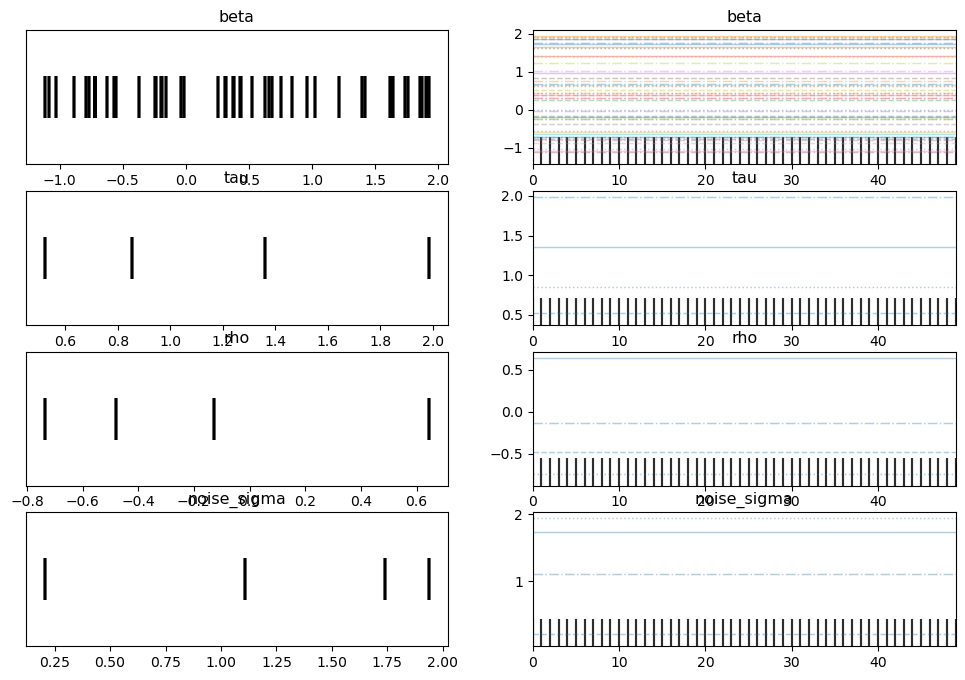

In [9]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False,
    jit_compile=True,
)
mcmc_samples, sampler_stats = run_mcmc(
    50,
    gam.experimental_pin(y_obs=co2_by_month_training_data["CO2"].values.T),
    n_chains=4,
    num_adaptation_steps=50,
    # Prepend batch index with [None]
    seed=tf.constant([-12341, 62345], dtype=tf.int32),
)

# https://github.com/seanpm2001/TensorFlow_Docs-l10n/blob/d442348ea44fd0f986bb7cdeb8a39ca9bfeb835d/site/ko/probability/examples/TFP_Release_Notebook_0_13_0.ipynb#L859
# jd = model.experimental_pin(y_obs=co2_by_month_training_data["CO2"].values.T)

# gam.
# 
# run_mcmc = tf.function(
#     tfp.experimental.mcmc.windowed_adaptive_hmc,
#     autograph=False,
#     jit_compile=True,
# )
# mcmc_samples, sampler_stats = run_mcmc(
#     50,
#     gam,
#     n_chains=1,
#     num_adaptation_steps=50,
#     num_leapfrog_steps=128,
#     # Prepend batch index with [None]
#     seed=tf.constant([-12341, 62345], dtype=tf.int32),
#     y_obs=co2_by_month_training_data["CO2"].values.T,
# )


regression_idata = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expects.
        k:np.swapaxes(v.numpy(), 1, 0)
        for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    }
)
regression_idata
axes = az.plot_trace(
    regression_idata,
    var_names=['beta', 'tau', 'rho', 'noise_sigma'],
    compact=True
)

In [10]:
sum(sampler_stats["accept_ratio"])

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>

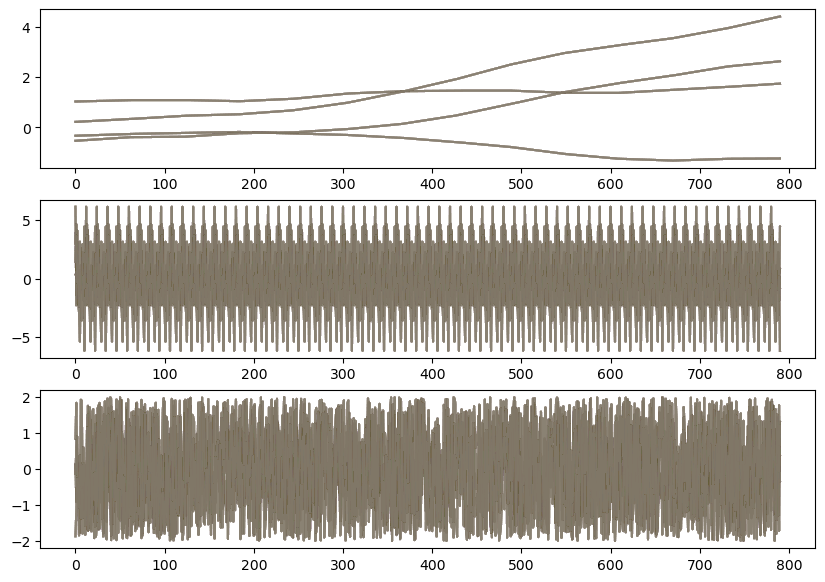

In [11]:
beta, k, m, tau, delta = [getattr(mcmc_samples, var) for var in ["beta","k","m","tau","delta"]]
grow_rate = k[..., None] + tf.einsum('ij,...j->...i', X_cp_all, delta)
y_offset  = m[..., None] + tf.einsum("ij,...j->...i", X_cp_all, -s * delta)
t = tf.cast(tf.linspace(0, 1, num_steps_all), np.float32)
y_trend = grow_rate * t + y_offset
y_season = tf.einsum('ij,...j->...i', X_season_all, beta)
temporal_error = mcmc_samples[-1]

fig,ax = plt.subplots(3,1, figsize=(10, 7))
for i in range(regression_idata.posterior.dims["chain"]):
    ax[0].plot(y_trend[-100:,i,:].numpy().T, alpha=.05)
    ax[1].plot(y_season[-100:,i,:].numpy().T, alpha=.05)
    ax[2].plot(temporal_error[-100:,i,:].numpy().T, alpha=.05)

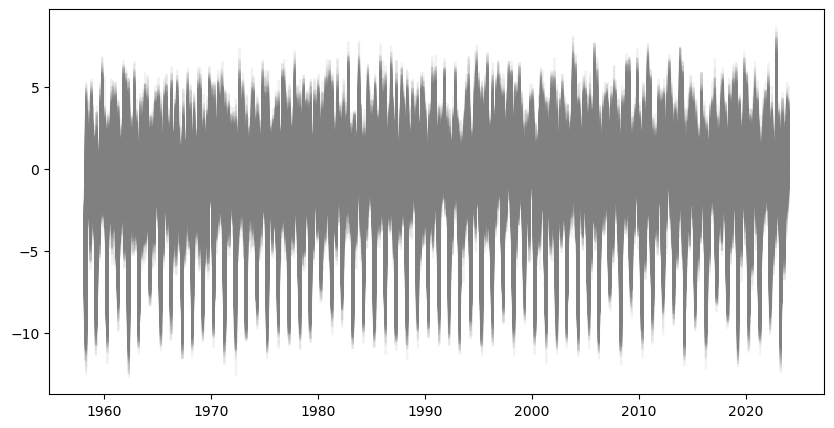

In [77]:
posterior_dists, predictive_samples = (
    generate_gam_ar1(X_cp_all, X_season_all, s, n_t = num_steps_all, n_holdout = 0)
    .sample_distributions(value=mcmc_samples)
)
fitted_with_forecast = predictive_samples[-1].numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(co2_by_month.index, fitted_with_forecast[-100:, 0, :].T, color='gray', alpha=.1);
ax.plot(co2_by_month.index, fitted_with_forecast[-100:, 1, :].T, color='gray', alpha=.1);